### Hybrid model for binary detect
- load dataset
- train model

In [1]:
import os
import time
import random
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader as Dataloader_dsm
from torch_geometric.loader import DataLoader as Dataloader_dot
import matplotlib.pyplot as plt
from gendata_binary import gendata
from gendata_binary import MyDataset
import torch.nn.functional as F
import numpy as np
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing, TopKPooling
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import degree

In [2]:
CWE = 190

load data time span: 354.3098797798157


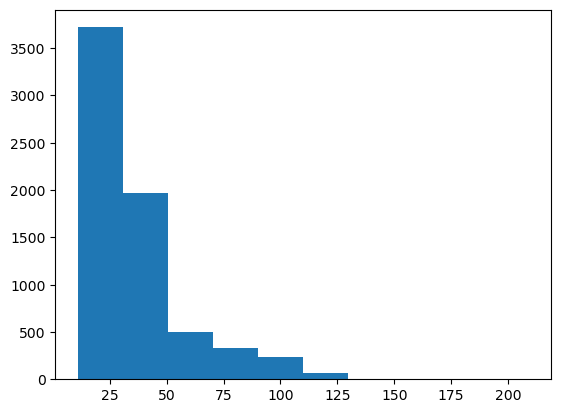

max of code text length: 209


In [3]:
# start load data
time_start = time.time()

dataset = gendata(CWE)
random.shuffle(dataset)
len_dataset = len(dataset)
dataset_dsm = []
dataset_dot = []
for data in dataset:
    dataset_dot.append(data[0])
    dataset_dsm.append(data[1])
print("load data time span:", time.time() - time_start)

dsm_height = []
for data in dataset_dsm:
    dsm_height.append(len(data['x']))
plt.hist(dsm_height)
plt.show()
print("max of code text length:", max(dsm_height))

In [4]:
size_token = [130, 45]

In [5]:
len_train = int(0.7 * len_dataset)
len_test = int(0.2 * len_dataset)
len_validate = len_dataset - len_train - len_test

Train_dot_loader = Dataloader_dot(dataset_dot[:len_train], batch_size=32, shuffle=False, drop_last=True)
Test_dot_loader = Dataloader_dot(dataset_dot[len_train: len_train+len_test], batch_size=32, shuffle=False, drop_last=True)

Train_dsm_loader = Dataloader_dsm(MyDataset(dataset_dsm[:len_train], size_token), batch_size=32, shuffle=False, drop_last=True)
Test_dsm_loader = Dataloader_dsm(MyDataset(dataset_dsm[len_train: len_train+len_test], size_token), batch_size=32, shuffle=False, drop_last=True)

print(f"len of dataset:{len_dataset}, \
        len of train:{len_train}, \
        len of validate:{len_validate}, \
        len of test:{len_test}")

len of dataset:6840,         len of train:4788,         len of validate:684,         len of test:1368


In [6]:
# GCN layer
# cite: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__(aggr='add', **kwargs)  # "Add" aggregation (Step 5).
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x[N, in_channels]
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index

        deg = degree(col, x.size(0), dtype=x.dtype)

        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return  self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out

In [7]:
class HybridNet(torch.nn.Module):
    def __init__(self, size0, size1):
        super(HybridNet, self).__init__()
        ###############################################################################
        # GCN model   																  #
        ###############################################################################
        self.conv1 = GCNConv(256, 256)
        self.pool1 = TopKPooling(256, ratio=0.8)
        self.conv2 = GCNConv(256, 256)
        self.pool2 = TopKPooling(256, ratio=0.8)
        self.conv3 = GCNConv(256, 256)
        self.pool3 = TopKPooling(256, ratio=0.8)
        self.conv4 = GCNConv(256, 256)
        self.pool4 = TopKPooling(256, ratio=0.8)
        self.conv5 = GCNConv(256, 256)
        self.pool5 = TopKPooling(256, ratio=0.8)

        self.convAtt1 = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=1, stride=2)
        self.poolAtt1 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt2 = torch.nn.Conv1d(64, 16, kernel_size=1, stride=2)
        self.poolAtt2 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt3 = torch.nn.Conv1d(16, 2, kernel_size=1, stride=2)
        self.poolAtt3 = torch.nn.MaxPool1d(kernel_size=1, stride=2)

        self.convAtt4 = torch.nn.Conv1d(2, 16, kernel_size=1, stride=2)
        self.poolAtt4 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt5 = torch.nn.Conv1d(16, 64, kernel_size=1, stride=2)
        self.poolAtt5 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt6 = torch.nn.Conv1d(64, 512, kernel_size=1, stride=2)
        self.poolAtt6 = torch.nn.MaxPool1d(kernel_size=1, stride=2)

        ###############################################################################
        # textCNN model   															  #
        ###############################################################################
        h_input = size0
        w_input = size1
        filter_list = [2, 4, 6, 8, 10, 12, 16, 20]
        num_per_filter = 64
        h_raw = [h_input - i + 1 for i in filter_list]  # 175-filter_size+1: after conv
        filter_list1 = [math.ceil(i / 2) for i in h_raw]  # p = ceil[h_raw / 2]
        self.num_filter = len(filter_list)
        self.conv_t = nn.ModuleList([nn.Conv2d(1, num_per_filter, (cnv_size, w_input)) for cnv_size in filter_list])
        self.max_t = nn.MaxPool2d(kernel_size=(num_per_filter, 1))
        self.avg_t = nn.AvgPool2d(kernel_size=(num_per_filter, 1))
        self.conv_t1 = nn.ModuleList([nn.Conv2d(2, 1, (cnv_size, 1), padding='same') for cnv_size in filter_list1])
        self.sig = nn.Sigmoid()
        h_res = sum(h_raw)  # textCNN_input_feature
        self.lin0_ = torch.nn.Linear(h_res, 512)
        ###############################################################################
        # hybrid output   															  #
        ###############################################################################
        # x: cfg 512  t:dsm 512
        #=============================================================================#
        # 方案1：只调比例 没有什么大用
        ratio = 0.2
        r_dot = round(ratio * 1024)
        r_dsm = 1024 - r_dot
        self.lin0x_ = torch.nn.Linear(512, r_dot)
        self.lin0t_ = torch.nn.Linear(512, r_dsm)
        self.lin1_ = torch.nn.Linear(1024, 512)
        self.lin2_ = torch.nn.Linear(512, 128)
        self.lin3_ = torch.nn.Linear(128, 64)
        self.lin4_ = torch.nn.Linear(64, 2)
        self.dropout_ = nn.Dropout(0.6)

        #=============================================================================#
        # # 方案2：
        # self.lin0x_ = torch.nn.Linear(512, 128)
        # self.lin0t_ = torch.nn.Linear(512, 128)
        #
        # self.lin1x_ = torch.nn.Linear(128, 16)
        # self.lin1t_ = torch.nn.Linear(128, 64)
        #
        # self.lin2x_ = torch.nn.Linear(80, 2)
        # # self.lin2t_ = torch.nn.Linear(64, 2)
        #
        # self.dropoutx_ = nn.Dropout(0.6)
        # self.dropoutt_ = nn.Dropout(0.6)

    def forward(self, x, edge_index, batch, t):
        ###############################################################################
        # GCN model :  x, edge_index, batch = data.x, data.edge_index, data.batch	  #
        ###############################################################################
        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        x4 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv5(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool5(x, edge_index, None, batch)
        x5 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4 + x5

        x = 1 / 5 * x

        sx = x

        x = x.unsqueeze(dim=2)

        # attention
        x = F.relu(self.convAtt1(x))
        x = self.poolAtt1(x)
        x = F.relu(self.convAtt2(x))
        x = self.poolAtt2(x)
        x = F.relu(self.convAtt3(x))
        x = self.poolAtt3(x)

        x = F.relu(self.convAtt4(x))
        x = self.poolAtt4(x)
        x = F.relu(self.convAtt5(x))
        x = self.poolAtt5(x)
        x = F.relu(self.convAtt6(x))
        x = self.poolAtt6(x)
        x = x.squeeze()

        x = (x + 1) * sx

        ###############################################################################
        # TextCNN model :  t = batch * h * w										  #
        ###############################################################################

        t = torch.unsqueeze(t, 1)  # batch, channel_in=1 , h, w
        t = [torch.squeeze(F.relu(conv(t)), 3) for conv in self.conv_t]  # each_filter: batch, channel_out=64, h'
        # t: num_filter * batch * num_per_filter=64 * h'

        # attention
        t = [torch.unsqueeze(i, 1) for i in t]  # num_filter * [ batch * 1 * num_per_filter=64 * h' ]

        max_ = [self.max_t(i) for i in t]  # num_filter * [batch * 1 * 1 * h' ]
        max_ = [torch.unsqueeze(torch.squeeze(i, 1), 3) for i in max_]  # num_filter * [batch * 1 * h' * 1]
        avg_ = [self.avg_t(i) for i in t]  # num_filter * [batch * 1 * 1 * h' ]
        avg_ = [torch.unsqueeze(torch.squeeze(i, 1), 3) for i in avg_]  # num_filter * [batch * 1 * h' * 1]

        attention = [torch.cat((max_[i], avg_[i]), dim=1) for i in range(0, self.num_filter)]  # num_filter * [batch * 2 * h' * 1]
        attention = [self.sig(self.conv_t1[i](attention[i])) for i in range(0, self.num_filter)]  # num_filter * [batch * 1 * h' * 1]
        attention = [torch.unsqueeze(torch.squeeze(i, 3), 1) for i in attention]  # num_filter * [batch * 1 * 1 * h']

        t = [t[i] * attention[i] for i in range(0, self.num_filter)]  # num_filter * [ batch * 1 * num_per_filter=64 * h' ]
        t = [torch.squeeze(self.max_t(i)) for i in t]  # num_filter * [batch * h']
        t = torch.cat(t, dim=1)  # batch * Σ(h')
        t = torch.squeeze(t)
        t = F.relu(self.lin0_(t))

        ###############################################################################
        # hybrid output :  #
        ###############################################################################
        # out layer
        # x = F.relu(self.lin0x_(x))
        # t = F.relu(self.lin0t_(t))
        #
        # x = self.dropoutx_(x)
        # t = self.dropoutt_(t)
        #
        # x = F.relu(self.lin1x_(x))
        # t = F.relu(self.lin1t_(t))
        #
        # x = torch.cat((t, x), dim=1)
        #
        # x = F.log_softmax(self.lin2x_(x), dim=-1)
        x = F.relu(self.lin0x_(x))
        t = F.relu(self.lin0t_(t))
        x = torch.cat((t,x), dim=1)
        x = F.relu(self.lin1_(x))
        x = F.relu(self.lin2_(x))
        x = self.dropout_(x)
        x = F.relu(self.lin3_(x))
        x = F.log_softmax(self.lin4_(x), dim=-1)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = HybridNet(size_token[0], size_token[1]).to(device)
model = HybridNet(size_token[0], size_token[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
def train(epoch):
    model.train()
    loss_all = 0
    iter_loader = iter(Train_dsm_loader)
    for data in Train_dot_loader:
        t, yy = next(iter_loader)
        t = t.to(device)

        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch

        optimizer.zero_grad()
        output = model(x, edge_index, batch, t)

        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(Train_dot_loader.dataset)

In [10]:
def test(loader0, loader1):
    # loader0:dot loader1:dsm
    model.eval()
    correct = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    pred_good = 0
    pred_bad = 0
    iter_loader = iter(loader1)
    for data0 in loader0:
        t, yy = next(iter_loader)
        t = t.to(device)

        data0 = data0.to(device)
        x, edge_index, batch = data0.x, data0.edge_index, data0.batch

        optimizer.zero_grad()
        y_pred = model(x, edge_index, batch, t)
        y_pred = y_pred.max(dim=1)[1]
        correct += y_pred.eq(data0.y).sum().item()
        for j in range(len(y_pred)):
            if y_pred[j] == 0 and data0.y[j] == 0:
                tp += 1
                pred_bad += 1
            elif y_pred[j] == 0 and data0.y[j] == 1:
                fp += 1
                pred_bad += 1
            elif y_pred[j] == 1 and data0.y[j] == 0:
                fn += 1
                pred_good += 1
            elif y_pred[j] == 1 and data0.y[j] == 1:
                tn += 1
                pred_good += 1
    acc = (tp + tn) / (tp + tn + fp + fn)
    return round(acc, 6), tp, fp, tn, fn, pred_good, pred_bad

In [11]:
# train & test
# time log
time_start = time.time()

train_loss_a = np.zeros(200)
test_acc_a = np.zeros(200)
best_acc = 0
best_acc_model = None
for epoch in range(0, 200):
    loss = train(epoch)
    if epoch % 4 == 0:
        train_acc, tp, fp, tn, fn, pred_good, pred_bad = test(Train_dot_loader, Train_dsm_loader)
        test_acc, tp, fp, tn, fn, pred_good, pred_bad = test(Test_dot_loader, Test_dsm_loader)
        if test_acc > best_acc:
            best_acc = test_acc
            best_acc_model = model
        train_loss_a[epoch] = loss
        test_acc_a[epoch] = test_acc
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f},Test Acc: {:.5f}, TP: {:02d}, FP: {:02d}, TN: {:02d}, FN: {:02d}, Pred_good: {:04d}, Pred_bad: {:04d}'.
            format(epoch, loss, train_acc, test_acc, tp, fp, tn, fn, pred_good, pred_bad))

# fin train & test;;print time span
time_fin_train = time.time()
print("train & test time span : ", time_fin_train - time_start)

D:\Develop\Miniconda\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 000, Loss: 0.28790, Train Acc: 0.98133,Test Acc: 0.97470, TP: 622, FP: 18, TN: 688, FN: 16, Pred_good: 0704, Pred_bad: 0640
Epoch: 004, Loss: 0.00615, Train Acc: 1.00000,Test Acc: 1.00000, TP: 638, FP: 00, TN: 706, FN: 00, Pred_good: 0706, Pred_bad: 0638
Epoch: 008, Loss: 0.00002, Train Acc: 1.00000,Test Acc: 1.00000, TP: 638, FP: 00, TN: 706, FN: 00, Pred_good: 0706, Pred_bad: 0638


KeyboardInterrupt: 

In [ ]:
# save the best test acc model
path_out_model = r'D:\Desktop\hybrid-SVD\model_out\CWE127.model'
model = model.to('cpu')
torch.save(model, path_out_model)


In [ ]:
x = np.arange(0, 200, 1)
plt.xlabel("iteration")
plt.ylabel("train loss")
plt.plot(x, train_loss_a[0:200])


In [ ]:
x = np.arange(0, 200, 1)
plt.xlabel("iteration")
plt.ylabel("test acc")
plt.plot(x, test_acc_a[0:200])

print("Best acc:", best_acc)
